In [ ]:
#!pip install --upgrade scipy

In [ ]:
import numpy as np
import pandas as pd
import json
import scipy
from scipy.stats import pearsonr, spearmanr
from concurrent.futures import ProcessPoolExecutor
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data.csv', sep=',(?=\S)', engine='python')

In [ ]:
df['friends'] = [json.loads(x) for x in df.friends]
df['id'] = [int(x.replace('"','')) for x in df.id]
df['screenName'] = [x.replace('"','') for x in df.screenName]

In [ ]:
df.head()

,id,screenName,tags,avatar,followersCount,friendsCount,lang,lastSeen,tweetId,friends
0,1969527638,LlngoMakeEmCum_,"[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/534286217...",319,112,"""en""",1472271687519,"""769310701580083200""","[1969574754, 1969295556, 1969284056, 196961221..."
1,51878493,_notmichelle,"[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/761977602...",275,115,"""en""",1472270622663,"""769309490038439936""","[60789485, 2420931980, 2899776756, 127410795, ..."
2,1393409100,jesseayye,"[ ""#narcos"" ]","""http://pbs.twimg.com/profile_images/713282938...",120,107,"""en""",1472804144409,"""771622623583186944""","[86868062, 19697415, 2998836604, 456295047, 74..."
3,232891415,MrBrianLloyd,"[ ""#gloryoutnow"" ]","""http://pbs.twimg.com/profile_images/133440668...",492,325,"""en""",1472269186776,"""769308131696467969""","[361335082, 1405248468, 24626354, 725675895965..."
4,710130422907207680,sarahdorat_16,"[ ""#nationaldogday"" ]","""http://pbs.twimg.com/profile_images/767180520...",128,218,"""en""",1472271397356,"""769309769144283137""","[1571896093, 768938323612008448, 2548665930, 3..."


In [ ]:
df[df.friendsCount < 300].id.nunique()

13164

## Friends Graph Network

In [ ]:
G = nx.Graph()

for index, row in df[df.friendsCount < 300].iterrows():
    user_id = row['id']
    friends = row['friends']
    for friend_id in friends:
        G.add_edge(user_id, friend_id)

In [ ]:
print("Nombre de noeuds :", G.number_of_nodes())
print("Nombre d'aretes :", G.number_of_edges())

Nombre de noeuds : 1655530
Nombre d'aretes : 2670645


<ipython-input-10-f784ae589822>:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample_nodes = random.sample(G.nodes(), 13164)


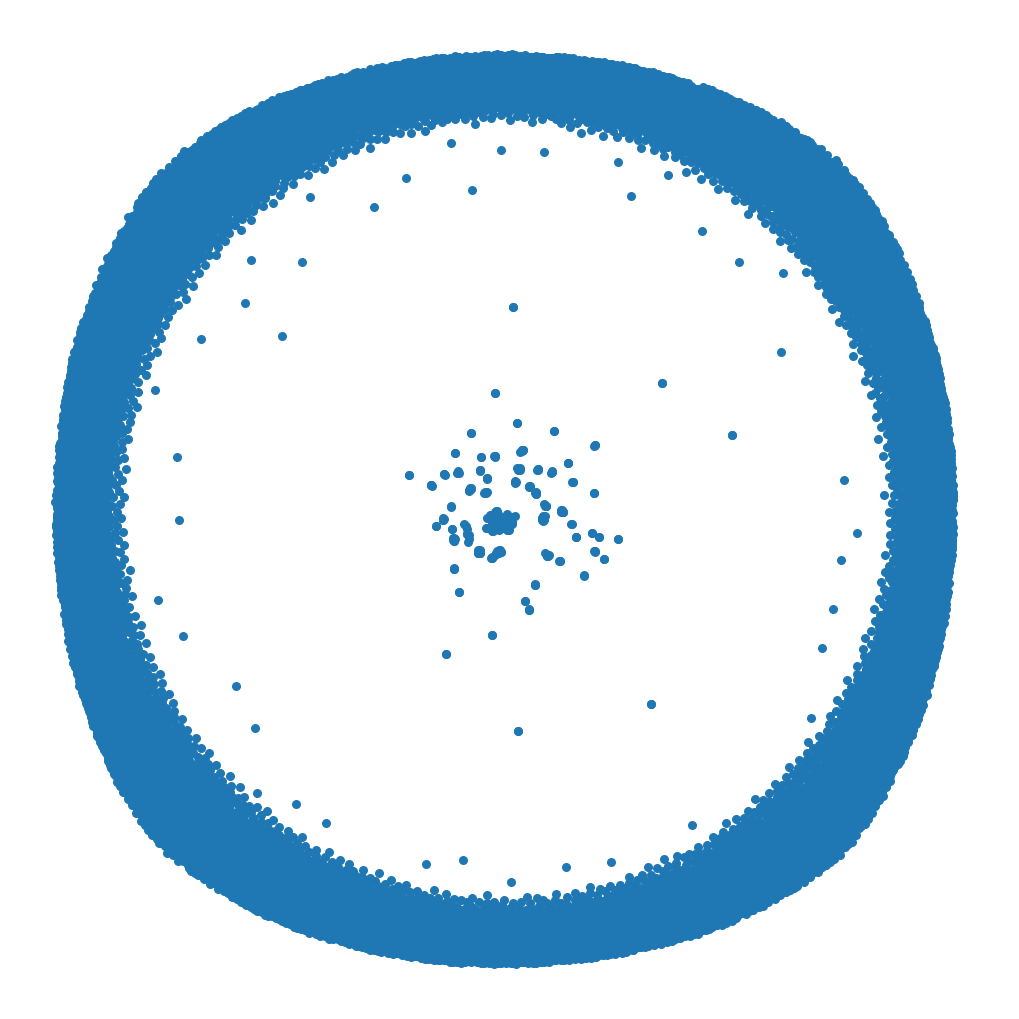

In [ ]:
# pour les noeuds aleatoire
sample_nodes = random.sample(G.nodes(), 13164)
subgraph = G.subgraph(sample_nodes)

plt.figure(figsize=(10, 10))
nx.draw(subgraph, with_labels=False, node_size=30, edge_color='gray')
plt.show()

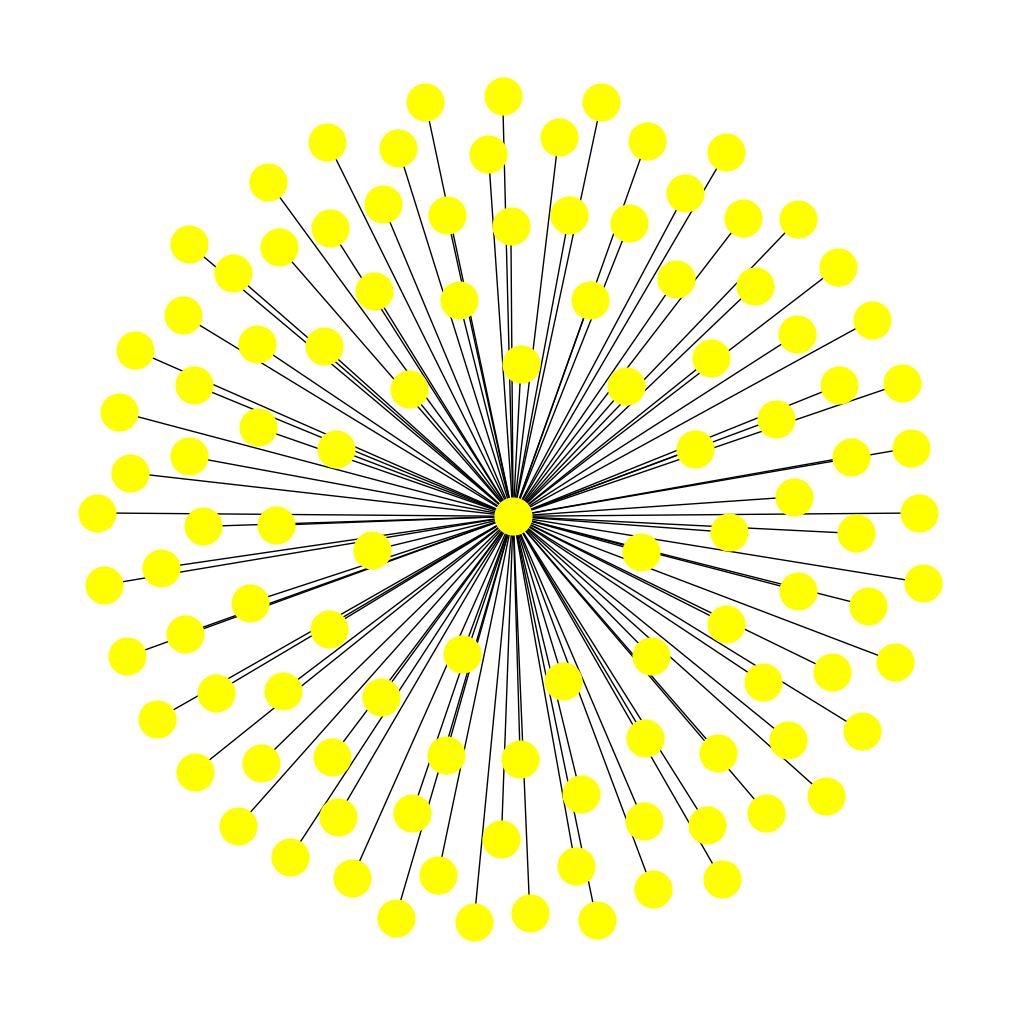

In [ ]:
# pour les noeuds et leurs voisins
node_id = 1393409100

if node_id in G:
    neighbors = list(G.neighbors(node_id))
    nodes_to_draw = neighbors + [node_id]
    subgraph = G.subgraph(nodes_to_draw)
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=False, node_size=700, node_color='yellow')
    plt.show()

# Graph Analysis

## Graph Centrality

In [ ]:
degree_centrality = nx.degree_centrality(G)

In [ ]:
top_users_dc = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Meilleurs 10 des utilisateurs par degré de centralité :", top_users_dc)

Meilleurs 10 des utilisateurs par degré de centralité : [('221412285', 0.001252167736113351), ('59325073', 0.001188139863451501), ('16712746', 0.0011851196807787722), ('266336410', 0.0010975343832696377), ('15846407', 0.0009990764281386795), ('181561712', 0.0009344445189422837), ('53338746', 0.0009072628748877247), ('17919972', 0.0008704166462804335), ('105119490', 0.0008444430752949661), ('27260086', 0.0008317583080695052)]


In [ ]:
high_degree_nodes = [item[0] for item in top_users_dc[:2]]
high_degree_nodes

['221412285', '59325073']

## Analysis Subgraph

In [ ]:
degree_threshold = 10
high_degree_nodes = [node for node, degree in dict(G.degree()).items() if degree > degree_threshold]

H = G.subgraph(high_degree_nodes)

In [ ]:
print("Nombre de noeuds :", H.number_of_nodes())
print("Nombre d'aretes :", H.number_of_edges())

Nombre de noeuds : 28136
Nombre d'aretes : 655492


## Find communities

In [ ]:
partition = community_louvain.best_partition(H)

In [ ]:
# Creation d'un dictionnaire pour stocker les noeuds par communaut3
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

communities_tlist = []
communities_to_display = {}

# Production des statistiques des communites
for comm_id, nodes in communities.items():
    if len(nodes) > 1:
        subgraph = H.subgraph(nodes)
        degree_centrality = nx.degree_centrality(subgraph)
        # Trouver le noeud avec une centralite maximale
        central_node = max(degree_centrality, key=degree_centrality.get)
        print(f"Communite {comm_id}: {len(nodes)} noeud, Centralite du Noeud : {central_node}")
        if len(nodes) < 500: communities_tlist.append(comm_id)

for key in communities_tlist:
    communities_to_display[key] = None

Communite 12: 7338 noeud, Centralite du Noeud : 266336410
Communite 1: 5148 noeud, Centralite du Noeud : 221412285
Communite 13: 489 noeud, Centralite du Noeud : 335141638
Communite 3: 5062 noeud, Centralite du Noeud : 26257166
Communite 22: 6789 noeud, Centralite du Noeud : 15846407
Communite 5: 1154 noeud, Centralite du Noeud : 379408088
Communite 6: 1289 noeud, Centralite du Noeud : 739476262398234624
Communite 7: 344 noeud, Centralite du Noeud : 761281919770386434
Communite 96: 313 noeud, Centralite du Noeud : 16409683


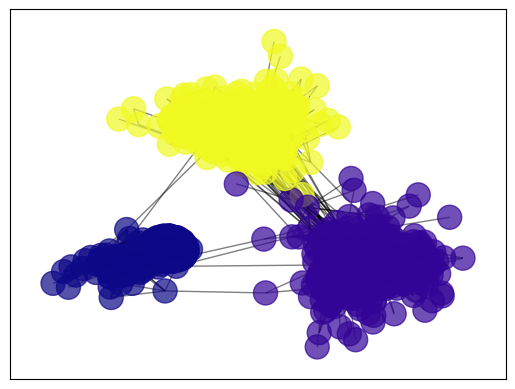

In [ ]:
nodes_to_display = [node for node, comm_id in partition.items() if comm_id in communities_to_display]

subgraph = H.subgraph(nodes_to_display)

pos = nx.spring_layout(subgraph)
cmap = plt.colormaps['plasma']
nx.draw_networkx_nodes(subgraph, pos, node_color=[partition[node] for node in subgraph], cmap=cmap, alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, alpha=0.5)
plt.show()
